In [297]:
using Pkg
Pkg.activate("/home/users/shubhgup/Codes/Julia/TISExperiments.jl")

  Activating environment at `~/Codes/Julia/TISExperiments.jl/Project.toml`


In [298]:
using Revise

In [437]:
using POMDPs, POMDPGym, POMDPSimulators, POMDPPolicies, Distributions
using BSON
using SARSOP, Random
using POMCPOW
using BeliefUpdaters
using ParticleFilters
using FileIO
using TISExperiments
using POMDPGifs
using D3Trees
# using Interact
using TreeImportanceSampling
include("gridworld_mdp.jl")

In [438]:
using Plots
using ProgressMeter

In [439]:
adv_rewards, amdp = gen_gridworld_mdp(penalty_mul=1, maxT=20)

(Dict{SVector{2, Int64}, Float64}([10, 4] => 1.230999766183066, [6, 10] => 0.25268388016212295, [4, 5] => 0.4205550987639115, [6, 8] => 1.2270422445234832, [2, 3] => 0.42176969965313926, [10, 3] => 0.5639741650275885, [9, 6] => 1.7603781636265028, [5, 1] => 1.9178517526594696, [4, 2] => 1.204595160532766, [8, 7] => 0.2313753293494889…), RMDP{SVector{2, Int64}, Symbol}
  amdp: GridWorldMDP
  π: NoisyGridWorldPolicy NoisyGridWorldPolicy()
  cost_fn: costfn (function of type var"#costfn#979")
  include_time_in_state: Bool false
  dt: Int64 1
  maxT: Int64 20
  disturbance_type: Symbol action
)

In [440]:
# fixed_s = rand(initialstate(amdp))
fixed_s = SVector(4, 9)

2-element SVector{2, Int64} with indices SOneTo(2):
 4
 9

In [441]:
actions(amdp, fixed_s)

GenericDiscreteNonParametric([:up, :down, :left, :right], DiscreteNonParametric{Int64, Float64, Vector{Int64}, Vector{Float64}}(support=[1, 2, 3, 4], p=[0.003333333333333336, 0.003333333333333336, 0.003333333333333336, 0.99]))

In [442]:
N = 10_000
c = 0.0
α = 1e-3

β = 0.01
γ = 0.01

schedule = 1.0 # set to Inf to switch off

uniform_floor = 1e-6 # set to 0.0 to switch off

baseline = false
base_continue = false

path = "data/pendulum_topple";

if base_continue
    baseline_costs = load("$(path)_baseline_$(N).jld2")["risks"]
else
    baseline_costs = []
end


Any[]

In [443]:
simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> rand(actions(amdp, s))), fixed_s)

14-element SimHistory{NamedTuple{(:s, :a, :sp, :r, :info, :t, :action_info), Tuple{SVector{2, Int64}, Symbol, SVector{2, Int64}, Float64, Nothing, Int64, Nothing}}, Float32}:
 (s = [4, 9], a = :right, sp = [5, 9], r = 0.2831898194149063, info = nothing, t = 1, action_info = nothing)
 (s = [5, 9], a = :right, sp = [6, 9], r = 1.4370727693323597, info = nothing, t = 2, action_info = nothing)
 (s = [6, 9], a = :down, sp = [6, 8], r = 1.2212033203841202, info = nothing, t = 3, action_info = nothing)
 (s = [6, 8], a = :down, sp = [6, 7], r = 1.2270422445234832, info = nothing, t = 4, action_info = nothing)
 (s = [6, 7], a = :right, sp = [7, 7], r = 0.02107806195361217, info = nothing, t = 5, action_info = nothing)
 (s = [7, 7], a = :down, sp = [7, 6], r = 0.667362102325149, info = nothing, t = 6, action_info = nothing)
 (s = [7, 6], a = :down, sp = [7, 5], r = 1.115987996524853, info = nothing, t = 7, action_info = nothing)
 (s = [7, 5], a = :down, sp = [7, 4], r = 1.8179559125187947, info 

In [444]:
function heatmap_plot!(p, costs)
    xs = [i for i=1:10]
    ys = [i for i=1:10]
    C = fill(NaN, 10, 10)
    max_cost = max(values(costs)...)
    min_cost = min(values(costs)...)
    for (key, value) in costs
#         if 45<value<55
#             value = 1.5
#         elseif 95<value<105
#             value = 2
#         end
        C[key[1], key[2]] = value
    end
    heatmap!(p, xs, ys, C, clims=(min_cost, max_cost), c=:jet, alpha=0.3)
end

heatmap_plot! (generic function with 2 methods)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


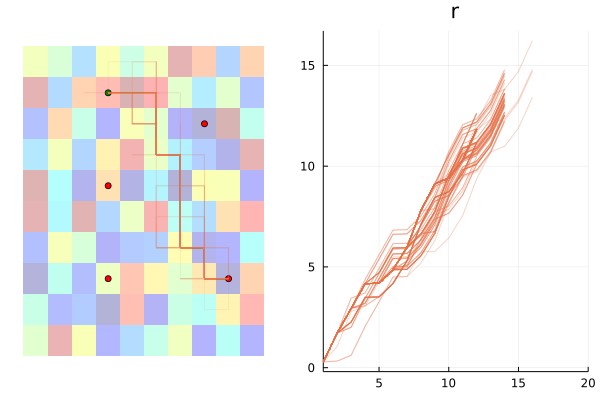

In [445]:
function plot_path(history; plots = [], idx=1)
    
    if length(plots)==0
        p = plot(xlim=(0, 11), ylim=(0, 11), legend=false, grid = false, axis=([], false))
        heatmap_plot!(p, adv_rewards)
        scatter!(p, [history[1].s[1]], [history[1].s[2]], color=:green)
        for s_term in amdp.amdp.g.terminate_from
            scatter!(p, [s_term[1]], [s_term[2]], color=:red)
        end
        push!(plots, p)
        
        p = plot(xlim = (1, amdp.maxT), title = "r", legend=false)
        push!(plots, p)
    end
    
    xs = [step.s[1] for step in history]
    ys = [step.s[2] for step in history]
    costs_l = cumsum([step.r for step in history])
#     @show xs, ys, costs_l
    plot!(plots[1], xs, ys, alpha=0.1, color=idx)
    
    plot!(plots[2], costs_l, alpha=0.3, color=idx)
    
    
    return plots
end
plots = []

@showprogress for i=1:1000
    history = simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> rand(actions(amdp, s))), fixed_s);
    plots = plot_path(history; plots=plots, idx=2)
end
plot(plots...)

In [446]:
@showprogress for i=1:N
    cost = sum(collect(simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> rand(actions(amdp, s))), fixed_s)[:r]))
#     cost = sum(collect(simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> [0.0, 0.0, 0.0]), fixed_s)[:r]))
    push!(baseline_costs, cost)
end
# baseline_costs_1 = baseline_costs

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


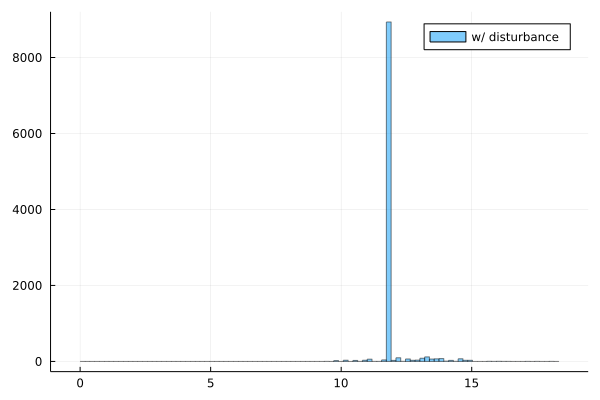

In [447]:
# p = histogram(plot_costs[1][2], label="$(plot_costs[1][1])", alpha=0.4, bins=100)
# for x in plot_costs[end:end]
#     histogram!(x[2], label="$(x[1])", alpha=0.4, bins=100)
# end
# p
max_cost = max(baseline_costs...)
histogram(baseline_costs, alpha=0.5, label="w/ disturbance", bins=0:max_cost/100:max_cost)
# histogram!(baseline_costs_1, alpha=0.5, label="w/o disturbance", bins=1:6:600)

In [448]:
# print("Starting grid search...")
# mc_samps = load("data/gridworld_baseline_10000000.jld2")["risks"]
# mc_samps = [Float64(samp) for samp in mc_samps]

# TISExperiments.run_grid_search(amdp, fixed_s, disturbance, mc_samps, ones(length(mc_samps)), path)
# TISExperiments.run_grid_search(amdp, tree_mdp, fixed_s, disturbance, mc_samps, ones(length(mc_samps)), path; N_l=[1_000_000], save_every=1)
# TISExperiments.run_grid_search(amdp, tree_mdp, fixed_s, disturbance, mc_samps, ones(length(mc_samps)), path; N_l=[10_000], α_l=[1e-2], β_a_l=[0.5], β_b_l=[0.3], schedule_l = [0.1])

# print("...Completed.")


# results_baseline, results_tis, planner = TISExperiments.run_baseline_and_treeIS(amdp, fixed_s, disturbance; N, c, α, β, γ, schedule, uniform_floor, baseline)

tree_mdp = construct_tree_amdp(amdp, disturbance; reduction="sum")
planner = TreeImportanceSampling.mcts_isdpw(tree_mdp; N=N, c, α)
tree_fixed_s = TreeImportanceSampling.TreeState(fixed_s);
traj_plots = [];

In [449]:
a, info = TreeImportanceSampling.action_info(planner, tree_fixed_s; tree_in_info=true, N=100, c, α, β, γ, schedule, uniform_floor, baseline)
tis_output = (planner.mdp.costs, [], planner.mdp.IS_weights, info[:tree]);

"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


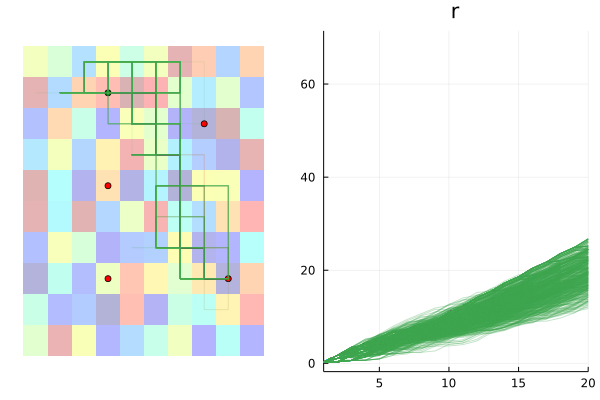

In [450]:
lookup = TreeImportanceSampling.mdp_state_lookup(planner)
# plots = []
@showprogress for i=1:1000
    history = simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> TreeImportanceSampling.tree_policy(planner, s, lookup; schedule=schedule)), fixed_s);
    plots = plot_path(history; plots=plots, idx=3)
end
plot(plots...)
# planner.tree.cdf_est
# planner.tree.total_n
# planner.mdp.costs

In [451]:
D3Tree(planner.tree.dpw_tree)

[4, 9]
N:  10000

├──                       up
│  Q:  15.28
│  N:    303

│  └──                  [4, 10]
│     N:    302

│     ├──                       up
│     │  Q:  13.94
│     │  N:      1
 (1 children)
│     ├──                     down
│     │  Q:  12.90
│     │  N:      1
 (1 children)
│     ├──                     left
│     │  Q:  15.62
│     │  N:     52
 (1 children)
│     └──                    right
│        Q:  15.24
│        N:    248
 (1 children)
├──                     down
│  Q:  10.44
│  N:     27

│  └──                   [4, 8]
│     N:     26

│     ├──                       up
│     │  Q:  12.28
│     │  N:      2
 (1 children)
│     ├──                     down
│     │  Q:  10.19
│     │  N:      1
 (1 children)
│     ├──                     left
│     │  Q:  11.42
│     │  N:      1
 (1 children)
│     └──                    right
│        Q:  10.27
│        N:     22
 (1 children)
├──                     left
│  Q:  12.99
│  N:    148

│  └──                   [3, 9]
│     N:    147

│     ├──                       up
│     │  Q:  15.88
│     │  N:      9
 (1 children)
│     ├──                     down
│     │  Q:  11.32
│     │  N:      1
 (1 children)
│     ├──                     left
│     │  Q:  14.21
│     │  N:      7
 (1 children)
│     └──                    right
│        Q:  12.75
│        N:    130
 (1 children)
└──                    right
   Q:  13.27
   N:   9522

   └──                   [5, 9]
      N:   9521

      ├──                       up
      │  Q:  15.52
      │  N:    230
 (1 children)
      ├──                     down
      │  Q:  11.46
      │  N:     55
 (1 children)
      ├──                     left
      │  Q:  15.79
      │  N:    260
 (1 children)
      └──                    right
         Q:  13.15
         N:   8976
 (1 children)

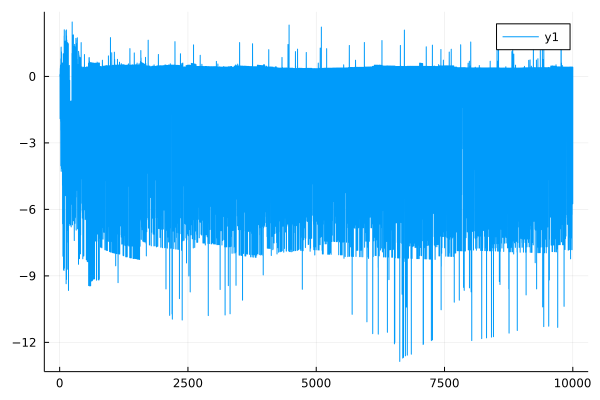

In [452]:
plot(planner.mdp.IS_weights)

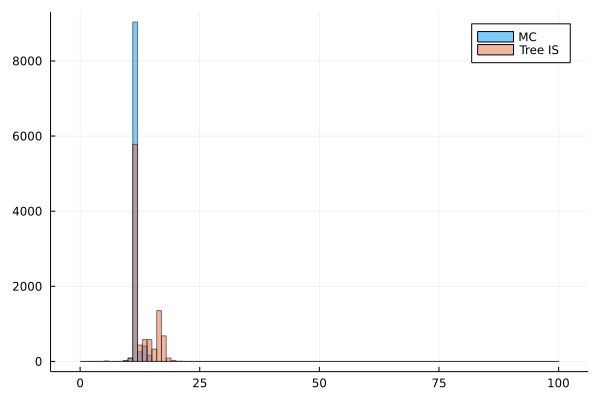

In [453]:
tis_range = (1, length(tis_output[1]))
histogram(baseline_costs[tis_range[1]:tis_range[2]], alpha=0.5, label="MC", bins=0:1:100)
histogram!(planner.mdp.costs[tis_range[1]:tis_range[2]], alpha=0.5, label="Tree IS", bins=0:1:100)
# ylims!(0, 100)

In [ ]:

# print("Baseline metrics")

# TISExperiments.evaluate_metrics(baseline_costs; alpha_list=[1e-3])

# print("\nTIS metrics: N=$(N), c=$(c), α=$(α), β=$(β)), γ=$(γ)")

# TISExperiments.evaluate_metrics(tis_output[1][tis_range[1]:tis_range[2]]; weights=exp.(tis_output[3][tis_range[1]:tis_range[2]]), alpha_list=[1e-3])

# if baseline
# save("$(path)_baseline_$(N).jld2", Dict("risks" => baseline_costs, "states" => []))
# # else
# #     save("$(path)_mcts_IS_$(N).jld2", Dict("risks" => results_tis[1], "states" => results_tis[2], "IS_weights" => results_tis[3], "tree" => results_tis[4]))
# # end

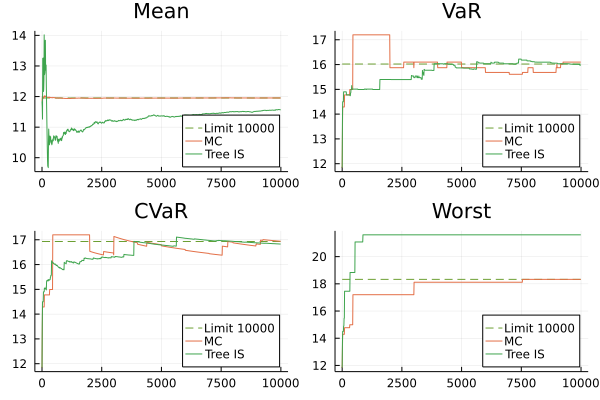

In [454]:
TISExperiments.plot_metrics([baseline_costs, baseline_costs, tis_output[1]]; weights_l=[nothing, nothing, exp.(tis_output[3])], range_l = tis_range, alpha=1e-3, names=["Limit", "MC", "Tree IS"], N_list = [2^i for i=1:10])